In [162]:
import numpy as np
import csv
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt

In [163]:
import camera_tools as ct

In [164]:
#Calibrate the camera to detect green box, if you haven't done this calibration before
low_green, high_green = ct.colorpicker()
print(low_green)
print(high_green)

[ 55  82 135]
[135  97 255]


In [ ]:
low_red, high_red = ct.colorpicker()
print(low_red)
print(high_red)d

In [232]:
#Check whether the camera detects the green object properly
cam = ct.prepare_camera()
img = ct.capture_image(cam)
ct.show_camera(cam, low_green, high_green)

In [ ]:
#Check whether the camera detects the green object properly
cam_red = ct.prepare_camera()
img_red = ct.capture_image(cam_red)
ct.show_camera(cam, low_red, high_red)

In [166]:
from FableAPI.fable_init import api
api.setup(blocking=True)

Dongle already connected
setup done


True

In [231]:
moduleids = api.discoverModules()
print("Module IDs: ", moduleids)
moduleID = moduleids[0]
print("Battery level:",api.getBattery(moduleID),"%")

Module IDs:  ['5YA ']
Battery level: 41.0 %


In [233]:
#Create two files (if they were not already created) to collect data.
if (not os.path.exists("xycoords_2.csv")):
    f = open('xycoords_2.csv', 'w')
    with f:
        writer = csv.writer(f)
        writer.writerows([["X","Y"]])
    f.close()
if (not os.path.exists("angles_2.csv")):
    f = open('angles_2.csv','w')
    with f:
        writer = csv.writer(f)
        writer.writerows([["Y_angle"]])
    f.close()

In [234]:
#we use the collectData function to collect the data for training.
    #we collect Y (angular) position of the end effector
    #we collect x,y coordinates of the end effector in the camera image
    #see the video final_project_guidance.mp4
def collectData(desired_angle_change):
    cam = ct.prepare_camera()
    ct.show_camera(cam)
    cam.release()
    cam = ct.prepare_camera()
    api.setPos(-90,90,moduleID)
    api.sleep(1.5)
    Y_angle_list = []
    XY_coordinates_list = []
    traversed_directions = 0
    current_direction = 0     # 1 is for clockwise, 0 is for anticlockwise
    traversedDirections = 0
    num_of_iterations = (int)(np.round(360/desired_angle_change,1))
    #Fable's Y arm traverse anticlockwise
    if current_direction == 0:
        for i in range(num_of_iterations):
            img = ct.capture_image(cam)
            x,y = ct.locate(img)
            currentRobotYAng = (int)(np.round(api.getPos(1,moduleID),1))
            Y_angle_list.append([currentRobotYAng])
            XY_coordinates_list.append([x,y])
            currentRobotYAng = currentRobotYAng - (desired_angle_change)
            api.setPos(-90,currentRobotYAng,moduleID)
            api.sleep(1.5)
            if np.abs(currentRobotYAng) > 90:
                current_direction = 1
                traversedDirections = traversedDirections + 1
                break
    #Fable's Y Arm traverses clockwise
    if current_direction == 1:
        for i in range(num_of_iterations):
            img = ct.capture_image(cam)
            x,y = ct.locate(img)
            currentRobotYAng = (int)(np.round(api.getPos(1,moduleID),1))
            Y_angle_list.append([currentRobotYAng])
            XY_coordinates_list.append([x,y])
            currentRobotYAng = currentRobotYAng + (desired_angle_change)
            api.setPos(-90,currentRobotYAng,moduleID)
            api.sleep(1.5)
            if np.abs(currentRobotYAng) > 90:
                current_direction = 0
                traversedDirections = traversedDirections + 1
                break
    if traversedDirections == 2:
        cam.release()
        #Save collected data to files
        y_angle_file_ptr = open('angles_2.csv', 'a+', newline ='')
        with y_angle_file_ptr:
            writer = csv.writer(y_angle_file_ptr)
            writer.writerows(Y_angle_list)
        y_angle_file_ptr.close()
        file_xycoords = open('xycoords_2.csv', 'a+', newline ='')
        with file_xycoords:
            writer = csv.writer(file_xycoords)
            writer.writerows(XY_coordinates_list)
        file_xycoords.close()
    return
    

In [235]:
#TODO: Call the CollectData() function with different values for 'desired_angle_change' argument and collect sufficient
#sufficient amout of data to angles_2.csv file and xycoords_2.csv file.
collectData(5)

In [236]:
#Use this function to calculate Y (angular) position errors 
# Y (angular) positions
def readAngleFilesAndCollectErrors(fileName):
    angleDataFrame = pd.read_csv(fileName)
    desired_column = angleDataFrame.columns[0]
    angle_error_list = []
    for i in range(1,len(angleDataFrame)):
        current_data_element = angleDataFrame[desired_column][i]
        previous_data_element = angleDataFrame[desired_column][i-1]
        #TODO: Calculate the Y (angular) position error(say current_error) as the difference between 
        # the current Y (angular) position and previous Y (angular) position
        current_error = current_data_element - previous_data_element
        #print(current_data_element," ", previous_data_element, " ", current_error)
        angle_error_list = angle_error_list + [current_error]
    return angle_error_list

In [237]:
#Use this function to calculate errors between x and y coordinates
def readXYCoordsFilesAndCollectErrors(fileName):
    xyCoordsDataFrame = pd.read_csv(fileName)
    x_col_name = xyCoordsDataFrame.columns[0]
    y_col_name = xyCoordsDataFrame.columns[1]
    x_pos_error_list = []
    y_pos_error_list = []
    for i in range(1,len(xyCoordsDataFrame)):
        current_data_element_x = xyCoordsDataFrame[x_col_name][i]
        current_data_element_y = xyCoordsDataFrame[y_col_name][i]
        previous_data_element_x = xyCoordsDataFrame[x_col_name][i-1]
        previous_data_element_y = xyCoordsDataFrame[y_col_name][i-1]
        error_x_pos = current_data_element_x - previous_data_element_x 
        error_y_pos = current_data_element_y - previous_data_element_y
        x_pos_error_list = x_pos_error_list + [error_x_pos]
        y_pos_error_list = y_pos_error_list + [error_y_pos] 
    return [x_pos_error_list,y_pos_error_list]

In [238]:
#Read the provided files and load the calculated errors into to appropriate lists as follows
angle_error_list_1 = readAngleFilesAndCollectErrors("angles_1.csv")
x_pos_error_list_1,y_pos_error_list_1 = readXYCoordsFilesAndCollectErrors("xyCoords_1.csv")
#Read the files with the data dumped by you and load the calculated errors into appropriate lists.
angle_error_list_2 = readAngleFilesAndCollectErrors("angles_2.csv")
x_pos_error_list_2,y_pos_error_list_2 = readXYCoordsFilesAndCollectErrors("xyCoords_2.csv")

In [240]:
#merge both angle_error_list_1 and angle_error_list_2 to a single list and make it a numpy array called 'angle_error_array'
# angle_error_array = np.array(angle_error_list_1 + angle_error_list_2 )
angle_error_array = angle_error_list_2
#merge both x_pos_error_list_1 and x_pos_error_list_2 to a single list and make it a numpy array called 'x_coord_error_array'
# x_coord_error_array = np.array(x_pos_error_list_1 + x_pos_error_list_2)
x_coord_error_array = x_pos_error_list_2
#merge both y_pos_error_list_1 and y_pos_error_list_2 to a single list and make it a numpy array called 'y_coord_error_array'
# y_coord_error_array = np.array(y_pos_error_list_1 + y_pos_error_list_2)
y_coord_error_array = y_pos_error_list_2

In [ ]:
# data = np.array([angle_error_array,x_coord_error_array,y_coord_error_array])
# target = np.array([angle_error_array,x_coord_error_array,y_coord_error_array])

In [241]:
# Here we use 80% of the collected data  as the training set and 20% of the collected data as test set.
#TODO: Assign different propotions of the collected data set and test set and check how the test set error varies of the 
#Neural Network
data =  np.vstack((x_coord_error_array,y_coord_error_array)).T
target = np.vstack(angle_error_array)
# print(data)
# print(target)
data_input_tensor = torch.tensor(data.tolist()).float()
data_target_tensor = torch.tensor(target.tolist()).float()
data_with_target = torch.cat((data_input_tensor,data_target_tensor),1)
#TODO: what is the importance of using DataLoader utility function here?
loader= torch.utils.data.DataLoader(data_with_target,
                                     batch_size=data_with_target.size()[0], shuffle=True,
                                     num_workers=0)
#training set
train_set = []
#test set
test_set = []
for i in iter(loader):
    train_set_index = (int)(np.round(i.shape[0]*0.8))
    train_set = i[:train_set_index,:]
    test_set = i[train_set_index:,:]

In [242]:
print(train_set.shape)
print(test_set.shape)

torch.Size([66, 3])
torch.Size([16, 3])


In [243]:
#Defining Neural Network Model
class NN(torch.nn.Module):
    def __init__(self,n_feature,n_hidden1,n_hidden2,n_output):
        super(NN,self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature,n_hidden1)
        #self.do1 = torch.nn.Dropout(0.15)
        #self.relu1 = torch.nn.LeakyReLU()
        #self.bn1 = torch.nn.BatchNorm1d(n_hidden1,affine=False)
        self.hidden2 = torch.nn.Linear(n_hidden1,n_hidden2)
        #self.bn2 = torch.nn.BatchNorm1d(n_hidden2,affine=False)
        #self.relu2 = torch.nn.LeakyReLU()
        #self.do2 = torch.nn.Dropout(0.1)
        self.predict = torch.nn.Linear(n_hidden2,n_output)
        
        
    def forward(self,x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        #x = self.do1(x)
        x = self.hidden2(x)
        x = torch.sigmoid(x)
        #x = self.do2(x)
        x = self.predict(x)
        return x

In [244]:
#instantiate the Neural Network
#model = NN(n_feature=2,n_hidden1=17,n_hidden2=7, n_output=1)
model = NN(n_feature=2,n_hidden1=100,n_hidden2=100, n_output=1)

In [245]:
#Define loss function : 
# here we use Mean Square Error as the loss function
loss_func = torch.nn.MSELoss()

In [246]:
#Define the optimizer that should be used in training the Neural Network.
# Here 'lr' is the learning rate
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [247]:
train_set_inputs = train_set[:,:2]
#TODO: calculate the mean value of the train_set_inputs. 
mean_of_train_input = torch.mean(train_set_inputs,0)
#standard deviation of the train set inputs.
std_of_the_train_input = torch.std(train_set_inputs,0)
#here we normalize the inputs of the neural network. What is the importance of that?
normalized_train_set_inputs = (train_set_inputs - mean_of_train_input)/std_of_the_train_input

In [248]:
#targets of the training set
train_set_targets = train_set[:,2][:,np.newaxis]

In [249]:
print(normalized_train_set_inputs.shape)
print(train_set_targets.shape)

torch.Size([66, 2])
torch.Size([66, 1])


In [250]:
#TODO: train the Neural network model by changing the hyper parameters such as learning rate, number of epochs, number of neurons in hidden layers of the neural network.
# What is the minimum mean square error that you can achieve as your neural network converges for the training set.
#  (you will be able to achive a MSE of less than 10 as the Neural network converges.)
num_epochs = 10000
losslist = []
for _ in range(num_epochs):
    prediction = model(normalized_train_set_inputs) # Forward pass prediction. Saves intermediary values required for backwards pass
    loss = loss_func(prediction, train_set_targets) # Computes the loss for each example, using the loss function defined above
    optimizer.zero_grad() # Clears gradients from previous iteration
    loss.backward() # Backpropagation of errors through the network
    optimizer.step() # Updating weights
    # print("prediction =",prediction)
    # print("Loss: ", loss.detach().numpy())
    losslist.append(loss.detach().numpy())

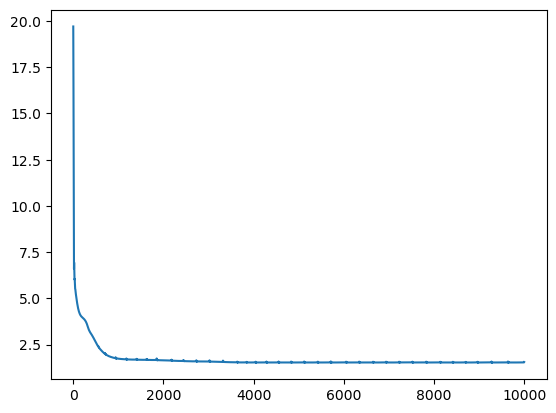

In [251]:
#plot the mean square error in each epoch/iteration
plt.plot(np.arange(len(losslist)),losslist)
plt.show()

In [252]:
#save the best neural network model you have obtained.
torch.save(model.state_dict(), 'best_nn_model.pth')

#Save the mean and standard deviation of the train set inputs because we need to use them at test time.

In [253]:
#reload the your best neural network model with saved parameters
model = NN(n_feature=2,n_hidden1=100,n_hidden2=100, n_output=1)
model.load_state_dict(torch.load('best_nn_model.pth'))

<All keys matched successfully>

In [254]:
#TODO: Extract inputs of the test_set
test_set_inputs = test_set[:,:2]
#TODO: Extract test set targets from the test_set
test_set_targets = test_set[:,2][:,np.newaxis]
print(test_set_inputs)

tensor([[ 12.,   0.],
        [-14.,   0.],
        [ -6.,   0.],
        [ -2.,   0.],
        [ -8.,  -2.],
        [ 14.,   0.],
        [ -6.,  -2.],
        [ -4.,   4.],
        [ -8.,   0.],
        [-10.,   2.],
        [ -6.,   0.],
        [ 22.,   2.],
        [ 14.,   0.],
        [ 10.,   0.],
        [  0.,   0.],
        [ 14.,  -3.]])


In [255]:
#TODO: Normalize test set inputs by using the mean and standard deviation of the inputs of the training set
train_numpy = train_set_inputs.numpy()
mean_of_train_input = np.mean(train_numpy, axis = 0)
# print(test_numpy)
# print(mean_of_test_input)
std_of_the_train_input = np.std(train_numpy,0)
normalized_test_set_inputs = (test_set_inputs - mean_of_train_input)/std_of_the_train_input
print(normalized_test_set_inputs)

tensor([[ 9.3309e-01,  3.7405e-04],
        [-1.0340e+00,  3.7405e-04],
        [-4.2872e-01,  3.7405e-04],
        [-1.2609e-01,  3.7405e-04],
        [-5.8003e-01, -4.9000e-02],
        [ 1.0844e+00,  3.7405e-04],
        [-4.2872e-01, -4.9000e-02],
        [-2.7741e-01,  9.9123e-02],
        [-5.8003e-01,  3.7405e-04],
        [-7.3134e-01,  4.9748e-02],
        [-4.2872e-01,  3.7405e-04],
        [ 1.6897e+00,  4.9748e-02],
        [ 1.0844e+00,  3.7405e-04],
        [ 7.8178e-01,  3.7405e-04],
        [ 2.5219e-02,  3.7405e-04],
        [ 1.0844e+00, -7.3688e-02]])


In [256]:
#TODO: feed the normalized test set inputs to the Neural Network model and obtain the prediction for the test set.
prediction_test = model(normalized_test_set_inputs)

In [257]:
print(prediction_test.shape)

torch.Size([16, 1])


tensor([[-4.9121],
        [ 4.1401],
        [ 3.4021],
        [ 4.2109],
        [ 0.9244],
        [-4.9403],
        [ 4.5830],
        [-7.4805],
        [ 1.0504],
        [ 4.4159],
        [ 3.4021],
        [-4.8995],
        [-4.9403],
        [-5.3167],
        [ 0.3729],
        [-4.9285]], grad_fn=<AddmmBackward0>)


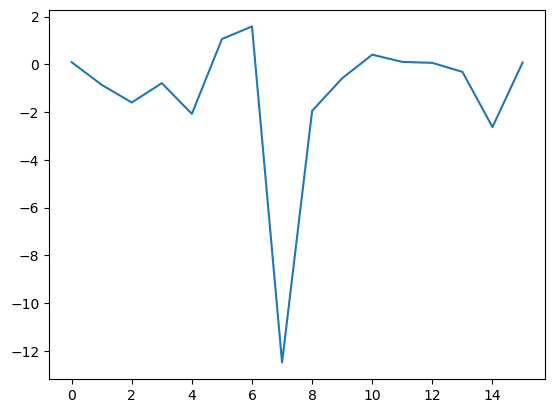

In [258]:
#plot the prediction error of the test set
test_set_prediction_error = prediction_test - test_set_targets
print(prediction_test)
# print(test_set_prediction_error)
plt.plot(np.arange(len(test_set_prediction_error.tolist())),test_set_prediction_error.tolist())

In [ ]:
# In the example model trained with about 600 data, from a test set of 165 samples,
# 159 samples are predicted with prediction error less than 10.

In [ ]:
#TODO: Based on the prediction error of the test set, you can try to train the neural network again by changing the hyper parameters mentioned above.
# Also Try to add Dropout layers to the Neural network and check whether test prediction errors can be reduced further.

# DETECTING THE OBJECT AT TESTING PHASE

In [272]:
#Here we implement the control loop which is having Neural Network as the controller.
#In this case we donot integrate CMAC to the control loop
def ControlLoopWithNNWithoutCMAC(target__x_coordinate,target__y_coordinate):
    
    number_of_iterations_for_convergence = 0
    #TODO:Intialize your best neural network model and load the saved paramemeters
    NN_model = NN(n_feature=2,n_hidden1=100,n_hidden2=100, n_output=1)
    NN_model.load_state_dict(torch.load('best_nn_model.pth'))

    #TODO: Obtain the x and y coodinates of the green box placed on the end effector of the robot
    
    #Here we loop for 50 iterations assuming that 
    # the controller should achieve the desired target within atmost 50 iterations
    for i in range(1000):
        cam = ct.prepare_camera()
        img = ct.capture_image(cam)
        x,y = ct.locate(img,low_green, high_green)
        robot_x_coord_in_image = x
        robot_y_coord_in_image = y
        x_coord_error = target__x_coordinate - robot_x_coord_in_image;
        y_coord_error = target__y_coordinate - robot_x_coord_in_image;
        #Here if the errors are less than twenty pixels we assume robot reaches the target. 
        # However you can choose any reasonable threshold value instead of 20.
        if (np.abs(x_coord_error) < 20 and np.abs(y_coord_error) < 20):
            print("number of iterations for convergence = ", number_of_iterations_for_convergence)
            break
        xy_input_nn_model = [x_coord_error,y_coord_error]
        print(xy_input_nn_model)
        #TODO: normalize the input to the Neural network model using meaning and variance of the training set inputs.
        normalize_xy_input_nn_model = (xy_input_nn_model - mean_of_train_input)/std_of_the_train_input
        # print(normalize_xy_input_nn_model)
        normalize_xy_input_nn_model_tensor = torch.tensor(normalize_xy_input_nn_model.tolist()).float()
        # print(normalize_xy_input_nn_model_tensor)
        prediction_for_Y_pos_increment = NN_model(normalize_xy_input_nn_model_tensor)
        # print(prediction_for_Y_pos_increment)
        #TODO: Get the current Y (angular) position/angle of the robot. you can use the api.getPos function of fable
        robot_current_Y_pos = api.getPos(1,moduleID)
        #Next Y angular position of the robot will be robot_Y_pos + prediction_for_Y_pos_increment
        robot_next_Y_pos = robot_current_Y_pos + prediction_for_Y_pos_increment
        print(robot_next_Y_pos)
        #TODO: Set the next position of the robot to (-90,robot_next_Y_pos) using the setPos function of the fable.
        api.setPos(-90,robot_next_Y_pos,moduleID)
        api.sleep(1.5)
        number_of_iterations_for_convergence = number_of_iterations_for_convergence + 1
    return


In [276]:
#TODO: Detect the target object and obtain the coordinates of the object in the image
cam = ct.prepare_camera()
img = ct.capture_image(cam)
# ct.show_camera(cam, low_green, high_green)
x,y = ct.locate(img,low_green, high_green)
target_x = x
target_y = y
print("target_x = ",target_x)

target_x =  292


In [277]:
api.setPos(-90,90,moduleID)

0

In [278]:
#TODO: Call the control loop for a target which is detected. Record the number of iterations that the control loop spent for convergence.
ControlLoopWithNNWithoutCMAC(target_x,target_y)
#TODO: change your target location and try again. You may change the target 4-5 times and check how the control loop work.
#Record the number of iterations that the control loop spent for convergence.

[158, 81]
tensor([83.8747], grad_fn=<AddBackward0>)
[160, 83]
tensor([78.0153], grad_fn=<AddBackward0>)
[158, 81]
tensor([72.1559], grad_fn=<AddBackward0>)
[158, 81]
tensor([66.5895], grad_fn=<AddBackward0>)
[158, 81]
tensor([61.3161], grad_fn=<AddBackward0>)
[154, 77]
tensor([55.7497], grad_fn=<AddBackward0>)
[149, 72]
tensor([50.1832], grad_fn=<AddBackward0>)
[144, 67]
tensor([44.6168], grad_fn=<AddBackward0>)
[138, 61]
tensor([39.0504], grad_fn=<AddBackward0>)
[128, 51]
tensor([33.7770], grad_fn=<AddBackward0>)
[116, 39]
tensor([28.5036], grad_fn=<AddBackward0>)
[102, 25]
tensor([22.9372], grad_fn=<AddBackward0>)
[86, 9]
tensor([17.3707], grad_fn=<AddBackward0>)
[68, -9]
tensor([12.0798], grad_fn=<AddBackward0>)
[48, -29]
tensor([7.9554], grad_fn=<AddBackward0>)
[32, -45]
tensor([4.1754], grad_fn=<AddBackward0>)
[20, -57]
tensor([7.7828], grad_fn=<AddBackward0>)
[30, -47]
tensor([2.8527], grad_fn=<AddBackward0>)
[14, -63]
tensor([6.0916], grad_fn=<AddBackward0>)
[24, -53]
tensor([0.

KeyboardInterrupt: 

In [116]:
cam = ct.prepare_camera()
img = ct.capture_image(cam)
# ct.show_camera(cam, low_green, high_green)
x,y = ct.locate(img,low_green, high_green)
target_x = x
target_y = y
print("target_x = ",target_x)

target_x =  296


In [ ]:
#Now integrate the CMAC to the previous control loop which had only the Neural Network. 
#The implementation of the CMAC can be found in code given for second week exercises.
#TODO: Implement the control loop with both neural network and CMAC. 
def ControlLoopWithBothNNandCMAC():
    
    return

In [ ]:
#TODO: Compare the number of iteration it takes for convergence in the control loop with 
# neural network only and with both CMAC and neural network.